In [11]:
  
__metaclass__=type
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#A class called 'Customer' that purchase items
#contains information used for statistics
class Customer:
    def __init__(self,arrival_time,service_start_time,service_time, item):
        self.arrival_time=arrival_time
        self.service_start_time=service_start_time
        self.service_time=service_time
        self.service_end_time=self.service_start_time+self.service_time
        self.wait=self.service_start_time-self.arrival_time
        self.item = item

#A class called 'Cashier' that allows customer to purshase items
#they can only handle one customer at a time and have to wait a particular
#service time determined by the cashier's service rate
class Cashier:
    def __init__(self,serviceRate):
        self.serviceRate = serviceRate
        self.available = True
        self.ServiceEnd= -1
    #checks if a cashier is free at a particular time and returns a boolean
    def checkAvailability(self,currentTime):
        if(currentTime>self.ServiceEnd):
            self.available =True
        return self.available
    #starts serving a particular custormer at the input time and for the input item
    def serve(self,serviceStartTime,item):
        self.ServiceEnd = serviceStartTime + neg_exp(self.serviceRate)
        self.available = False
        
#A class called Store that contains all the statistics of each store created
class Store:
    def __init__(self,Name,Num_Customer,Mean_Delay,Mean_service_Delay,Num_cust_on_Manager_q, stock):
        self.Name=Name
        self.Num_Customer=Num_Customer
        self.Mean_Delay=Mean_Delay
        self.Mean_service_Delay=Mean_service_Delay
        self.Num_cust_on_Manager_q=Num_cust_on_Manager_q
        self.stock = stock

#A class called StoreInProgress that shows a store's values in simulation since you only make the other 
#store at the end of its simulation for the statistics
class StoreInProgress:
    def __init__(self,stock_max,arrival_rate,cashiers,parent):
        self.stock_max = stock_max
        self.stock_current = stock_max
        self.stock_sold = [0,0,0]
        self.arrival_rate = arrival_rate
        self.Cashiers= cashiers
        self.customers= []
        self.customerWait = []
        self.Num_cust_on_Manager_q=0
        self.nextEvent=0
        self.parent = parent
    def replenish(self,item, amount):
        self.stock_current[item] = self.stock_current[item] + amount
    def sendRequest(self, item, amount):
        if(self.stock_current[item]>amount):
            self.stock_current[item] = self.stock_current[item]-amount
            return True
        else:
            return False
    
"""
unused Shelf class
class Shelf:
    def __init__(self,):
        self.Name=Name
        self.Num_Customer=Num_Customer
        self.Mean_Delay=Mean_Delay
        self.Mean_service_Delay=Mean_service_Delay
        self.Num_cust_on_Manager_q=Num_cust_on_Manager_q
"""
        
#a simple function to sample from negative exponential
def neg_exp(lambd):
    return random.expovariate(lambd)

def item_choose():
    return random.randint(0, 2)  # Random integer x, 1 <= x < 10

def Manager_Queue_Delay():
    return random.randint(10, 60)  # Random integer x, 1 <= x < 10

"""
    This is the main function to call to simulate all the stores.
"""
def StoreSim(lambd=False,mu=False,simulation_time=False):
    
    #The number of each item in a store
    max_Stock = [25,25,25]
    max_Stock2 = [15,25,17]
    max_Stock3 = [21,13,32]
    
    #If parameters are not input prompt
    if not lambd:
        lambd=input('Inter arrival rate: ')
        lambd=int(lambd)
    if not mu:
        mu=input('Service rate: ')
        mu=int(mu)
    if not simulation_time:
        simulation_time=input('Total simulation time: ')
        simulation_time=int(simulation_time)

    #Initialise clock
    t=0

    #Initialise empty lists to hold all data for cashiers and the list of arrival events
    Cashiers = []
    Cashiers2 = []
    Cashiers3 = []
    
    StoreEvents=[]
    
    
    #Declare all the cashiers for each store
    Cashiers.append(Cashier(neg_exp(5)))
    Cashiers.append(Cashier(neg_exp(7)))
    Cashiers.append(Cashier(neg_exp(3)))
    
    Cashiers2.append(Cashier(neg_exp(7)))
    Cashiers2.append(Cashier(neg_exp(3)))
    
    Cashiers3.append(Cashier(neg_exp(7)))
    Cashiers3.append(Cashier(neg_exp(3)))
    Cashiers3.append(Cashier(neg_exp(7)))
    Cashiers3.append(Cashier(neg_exp(3)))
    
   
    #create the actual stores with their stocks and cashiers
    Store1 = StoreInProgress(max_Stock,neg_exp(2), Cashiers,0)
    Store2 = StoreInProgress(max_Stock2,neg_exp(2), Cashiers2,1)
    Store3 = StoreInProgress(max_Stock3,neg_exp(2), Cashiers3,1)
    
    #put all the stores in easy to acess array
    stores = []
    stores.append(Store1)
    stores.append(Store2)
    stores.append(Store3)
    
    #calculate the arrival of the next customer for each store and save it in StoreEvents
    for store in stores:
        store.nextEvent = neg_exp(store.arrival_rate)
        StoreEvents.append(store.nextEvent)
    
    
#----------------------------------
#The actual simulation happens here:
    while t<simulation_time:
        #get customers next item and calculate arrival time of the next customer based on the
        #times in StoreEvents
        item = item_choose()
        next_arrival = StoreEvents[0]
        storeNum =0
        i =0
        for storeEvent in StoreEvents:
            if(storeEvent<next_arrival):
                next_arrival= storeEvent
                storeNum=i
            i= i+1
        
        #we first consider the case where the arrival time is the same as the start of the service time
        service_start_time = next_arrival
        #ass
        busy = False
        #i = 0
        #check if the item is in stock
        if stores[storeNum].stock_current[item]> 0:
            service_time=0
            available = False
            #look for an available cashier
            for cash in stores[storeNum].Cashiers:
                if(cash.checkAvailability(service_start_time)):
                    cash.serve(service_start_time,item)
                    service_time=cash.ServiceEnd - service_start_time
                    available = True
                    break
                
            #if no cashier is available wait for the next available Cashier and go when they become available
            if(not available):
                minTime = stores[storeNum].Cashiers[0].ServiceEnd
                chold = 0
                for cash in range(len(stores[storeNum].Cashiers)):
                    if(stores[storeNum].Cashiers[cash].ServiceEnd< minTime):
                        minTime = stores[storeNum].Cashiers[cash].ServiceEnd
                        chold = cash
                service_start_time = minTime
                stores[storeNum].Cashiers[chold].serve(service_start_time,item)
                service_time = stores[storeNum].Cashiers[chold].ServiceEnd - service_start_time
            #Update Stock in the store
            stores[storeNum].stock_current[item] = Store1.stock_current[item] - 1
            stores[storeNum].stock_sold[item] = Store1.stock_sold[item] + 1
            stores[storeNum].nextEvent = next_arrival + neg_exp(stores[storeNum].arrival_rate);
            StoreEvents[storeNum] = stores[storeNum].nextEvent
        else:
            service_time=neg_exp(mu)+Manager_Queue_Delay()
            stores[storeNum].Num_cust_on_Manager_q = stores[storeNum].Num_cust_on_Manager_q+1
            #replenish stock if out
                
            stores[storeNum].replenish(item,10)
        
        
        #create new customer and add him to Customers list of the store
        stores[storeNum].customers.append(Customer(next_arrival,service_start_time,service_time,item))
        
        #increment clock till next end of service
        t=next_arrival
#----------------------------------
    #create an index to mark each store and create and create an array to store the statistics of each store
    i2=0
    stats = []
    #Store statistics for each store in the stats array
    for store in stores:
        #calculate summary statistics
        Waits=[a.wait for a in store.customers]
        Mean_Wait=sum(Waits)/len(Waits)

        Total_Times=[a.wait+a.service_time for a in store.customers]
        Mean_Delay=sum(Total_Times)/len(Total_Times)

        Service_Times=[a.service_time for a in store.customers]
        Mean_Service_Delay=sum(Service_Times)/len(Service_Times)
        stats.append(Store('store'+str(i2),len(store.customers),Mean_Delay,Mean_Service_Delay,store.Num_cust_on_Manager_q,store.stock_current))
    
    #and return it
    return stats

In [12]:

#runs the simulation of stores and lets you input the time of the simlation    
def NetworkSim(num_store=False, simulation_time=False):
    """
    This is the main function to call to simulate the network.
    """
    
    if not simulation_time:
        simulation_time=input('Total simulation time: ')
        

    #Initialise empty list to collect store info
    Net_Stores= StoreSim(neg_exp(1), neg_exp(2), simulation_time)
    
    #map of medicine made
    item_map = ['Tynenol', 'Cold Medicine', 'Vitamins']
    
    j=0
    List_Mean_Delay =[]
    List_Num_Customer=[]
    List_Mean_service_Delay=[]
    List_Num_cust_on_Manager_q=[]

    print("\n%s Statistical Report %s\n" % (10*"=",10*"="))

    for store in Net_Stores:
        j = j+1
        List_Mean_Delay.append(store.Mean_Delay)
        List_Num_Customer.append(store.Num_Customer)
        List_Mean_service_Delay.append(store.Mean_service_Delay)
        List_Num_cust_on_Manager_q.append(store.Num_cust_on_Manager_q)

        print("")
        print("\n%s Summary for Store%d  %s\n" % (10*"=",j,10*"="))
        print("\t Mean number of Customer: %.02f\n" % store.Num_Customer)
        print("\t Mean Delay in Queue: %.02f\n" % store.Mean_Delay)
        print("\t Mean service time: %.02f\n" % store.Mean_service_Delay)
        print("\t Number Cust on Manager_q: %.02f\n" % store.Num_cust_on_Manager_q)
        print("\t Tynenol: %d\n" % store.stock[0])
        print("\t Cold Medicine: %d\n" % store.stock[1])
        print("\t Vitamins: %d\n" % store.stock[2])
    

    width = 0.35
    ind = np.arange(num_store) 

    plt.figure(1)  

    plt.subplot(221)
    plt.bar(ind, List_Mean_Delay, width, color='r')
    plt.title("Mean_Delay")

    plt.subplot(222)
    plt.bar(ind, List_Num_Customer, width, color='g')
    plt.title("Num_Customer")
     
    plt.subplot(223)
    plt.bar(ind, List_Mean_service_Delay, width, color='y')
    plt.title("Mean_service_Delay")

    plt.subplot(224)
    plt.bar(ind, List_Num_cust_on_Manager_q, width, color='b')
    plt.title("Num_cust_on_Manager_q")
    plt.show()
        
        #output summary statistics to screen
        #print ("")
        #print ("Store:", store.Name)
        #print ("Number of customers: ",store.Num_Customer)
        #print ("Mean Service Time: ",store.Mean_service_Delay)
        #print ("Mean Time in System: ",store.Mean_Delay)
        #print ("Number of Manager request: ",store.Num_Manager_resquest)
        #print ("")
        



========== Statistical Report ==========



========== Summary for Store1  ==========

	 Mean number of Customer: 112.00

	 Mean Delay in Queue: 99.54

	 Mean service time: 11.91

	 Number Cust on Manager_q: 5.00

	 Tynenol: 1

	 Cold Medicine: 10

	 Vitamins: 7



========== Summary for Store2  ==========

	 Mean number of Customer: 44.00

	 Mean Delay in Queue: 4.18

	 Mean service time: 4.14

	 Number Cust on Manager_q: 4.00

	 Tynenol: 2

	 Cold Medicine: 0

	 Vitamins: 9



========== Summary for Store3  ==========

	 Mean number of Customer: 91.00

	 Mean Delay in Queue: 9.53

	 Mean service time: 9.05

	 Number Cust on Manager_q: 7.00

	 Tynenol: 0

	 Cold Medicine: 10

	 Vitamins: 9



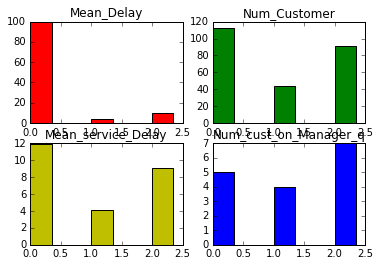

In [13]:
#here you put in the number of stores and the time of the simulation but there are only set 3 store right now
NetworkSim(3,200)

IndentationError: expected an indented block (<ipython-input-14-cbb7e169f58c>, line 4)